In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import math

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SequentialSampler
import pickle

import models.modeling as original
import models.modeling_bitlinear as binary
import models.modeling_bitlinear_158 as binary158


In [3]:
os.makedirs("attention_data", exist_ok=True)
#if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
#    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
#if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
#    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

#imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [4]:
# select device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Download CIFAR-10 (if it doesn't exist) and create the test loader
batch_size = 4

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

cifar10 = datasets.CIFAR10(root="attention_data", train=False, download=True, transform=transform_test)
cifar10_dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=False)

cifar100 = datasets.CIFAR100(root="attention_data", train=False, download=True, transform=transform_test)
cifar100_dataloader = DataLoader(cifar100, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Get labels
with open("attention_data/cifar-10-batches-py/batches.meta", 'rb') as labels_names:
    cifar10_labels = pickle.load(labels_names, encoding='bytes')[b'label_names']

#with open("attention_data/cifar-100-python/test", 'rb') as fo:
    #dict = pickle.load(fo, encoding='bytes')
    #print(dict.keys())
    #cifar100_labels = dict[b'fine_labels']
cifar100_labels = [i for i in range(1, 101)]

print(cifar100_labels)
print(cifar10_labels)
#print(cifar100_labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [7]:
# Base model used as starting point
#urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k%2Bimagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16.npz")

## Evluating Test Accuracy of Trained Models

+ Model weights and training logs can be found [here](https://drive.google.com/drive/u/2/folders/1o6YwUx-lfn0kfxaYC3NJm3I4hEBYuy2n)

In [8]:
def eval_model(model, dataloader, data_labels, warmup=True):
    model.eval()
    if warmup == True:
        for idx, batch in enumerate(dataloader):
            if idx == 5:
                break
            with torch.no_grad():
                images, labels = batch
                images = images.to(device)
                
                logits, _ = model(images)
            
    global_acc = 0
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    steps = math.ceil(len(dataloader.dataset)/batch_size)
    timings = np.zeros((steps, 1))
    
    num_labels = len(data_labels)
    confusion_matrix = np.zeros((num_labels, num_labels))
    
    for idx, batch in enumerate(dataloader):
        with torch.no_grad():
            images, labels = batch
            images = images.to(device)
            starter.record()
            logits, _ = model(images)
            ender.record()
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[idx] = curr_time
            
            for idx, image_logits in enumerate(logits):
                probs = torch.nn.Softmax(dim=-1)(image_logits)
                sorted_probs = torch.argsort(probs, dim=-1, descending=True)
                
                y_hat_index = sorted_probs[0].item()
                y_hat = data_labels[y_hat_index]
                
                y_index = labels[idx].item()
                y = data_labels[y_index]
                
                if y_hat == y:
                    global_acc += 1
                
                confusion_matrix[y_index][y_hat_index] += 1

    global_acc /= len(dataloader.dataset)
    print(f"acc: {global_acc}")

    mean_syn = np.sum(timings) / steps
    std_syn = np.std(timings)
    print(f"inference time: {mean_syn} ms")
    
    return confusion_matrix

In [9]:
def compute_metrics(cm, labels, annot=True, model_name = 'Baseline'):

    row_sums = np.sum(cm, axis=0)
    row_sums[row_sums == 0] = 1
    col_sums = np.sum(cm, axis=1)
    #col_sums[col_sums == 0] = 1
    
    precision = np.mean(np.diag(cm) / row_sums)
    recall = np.mean(np.diag(cm) / col_sums)
    F1 = 2 * (precision*recall)/(precision + recall)
    
    print(f'Precision:{precision}\nRecall:{recall}\nF1 Score:{F1}') 
    
    label_names = [x.decode('utf-8') if isinstance(x, str) else str(x) for x in labels]
    df_cm = pd.DataFrame(cm, index = label_names, columns = label_names)
    
    sns.heatmap(df_cm, annot=annot, cmap = 'OrRd', fmt = 'd')
    plt.title(f'{model_name}\n')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    
    plt.savefig(f'{model_name}_cm.png', bbox_inches='tight')

## Classification Accuracy on CIFAR-10

In [10]:
# Baseline finetune run
checkpoint_path = "output/cifar_10/baseline_checkpoint.bin"
config = original.CONFIGS["ViT-B_16"]
baseline_model = original.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
baseline_model.load_state_dict(checkpoint)

baseline_model

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [11]:
# CIFAR-10 Accuracy for baseline model
cifar10_baseline_cm = eval_model(baseline_model, cifar10_dataloader, cifar10_labels)

acc: 0.9904
inference time: 7.459675279045105 ms


Precision:0.9904147230719765
Recall:0.9904000000000002
F1 Score:0.9904073614812713


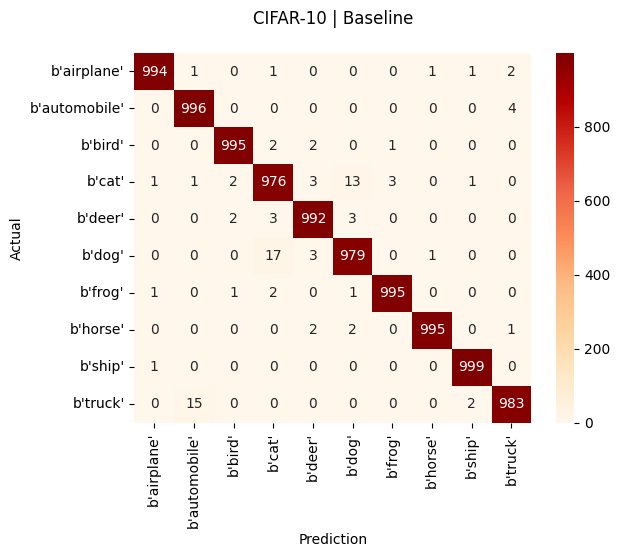

In [12]:
compute_metrics(cifar10_baseline_cm.astype(int), cifar10_labels, model_name = 'CIFAR-10 | Baseline')

In [13]:
# Binarized Run 10,000 iterations
checkpoint_path = "output/cifar_10/config1_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
bit_model1 = binary.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
bit_model1.load_state_dict(checkpoint)

print(bit_model1)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): BitLinear(in_features=768, out_features=3072, bias=True)
            (fc2): BitLinear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): BitLinear(in_features=768, out_features=768, bias=True)
            (key): BitLinear(in_features=768, out_features=768, bias=True)
            (value): BitLinear(in_features=768, out_features=768, bias=True)
            (out): BitLinear(in_features=768, out_feat

In [14]:
# CIFAR-10 Accuracy for Binarized Run 10,000 iterations
cifar10_1bit_10000_cm = eval_model(bit_model1, cifar10_dataloader, cifar10_labels)

acc: 0.3634
inference time: 22.459230515289306 ms


Precision:0.35327846628887255
Recall:0.36340000000000006
F1 Score:0.3582677607551542


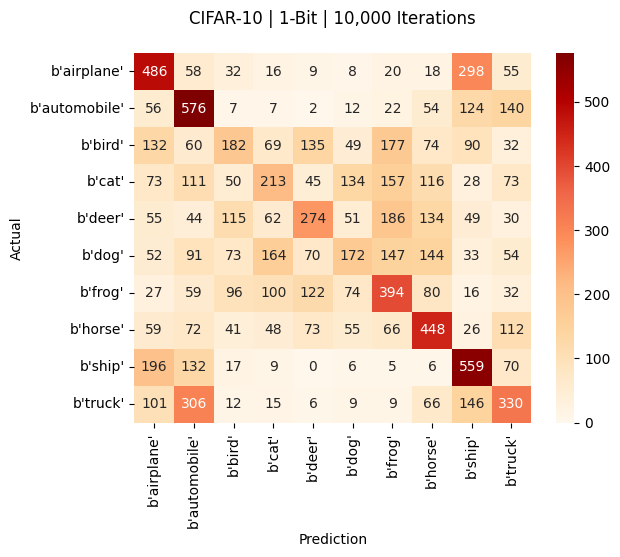

In [15]:
compute_metrics(cifar10_1bit_10000_cm.astype(int), cifar10_labels, model_name = 'CIFAR-10 | 1-Bit | 10,000 Iterations')

In [16]:
# Binarized Run 50,000 iterations
checkpoint_path = "output/cifar_10/config2_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
bit_model2 = binary.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
bit_model2.load_state_dict(checkpoint)

<All keys matched successfully>

In [17]:
# CIFAR-10 Accuracy for Binarized Run 50,000 iterations
cifar10_1bit_50000_cm = eval_model(bit_model2, cifar10_dataloader, cifar10_labels)

acc: 0.4361
inference time: 21.7749212348938 ms


Precision:0.43091100146936095
Recall:0.4361
F1 Score:0.4334899728430474


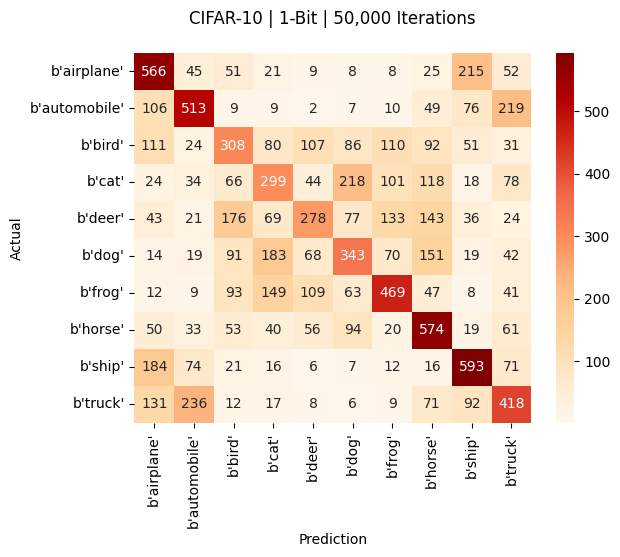

In [18]:
compute_metrics(cifar10_1bit_50000_cm.astype(int), cifar10_labels, model_name = 'CIFAR-10 | 1-Bit | 50,000 Iterations')

In [19]:
# Bit-1.58 Run 50,000 iterations
checkpoint_path = "output/cifar_10/config3_checkpoint.bin"
config = binary158.CONFIGS["ViT-B_16"]
bit158_model = binary158.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
bit158_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:
# TODO: run this cell
# CIFAR-10 Accuracy for Binarized Run 50,000 iterations
cifar10_158bit_50000_cm = eval_model(bit158_model, cifar10_dataloader, cifar10_labels)

acc: 0.9581
inference time: 30.746241423797606 ms


Precision:0.9583130856159066
Recall:0.9581
F1 Score:0.9582065309614782


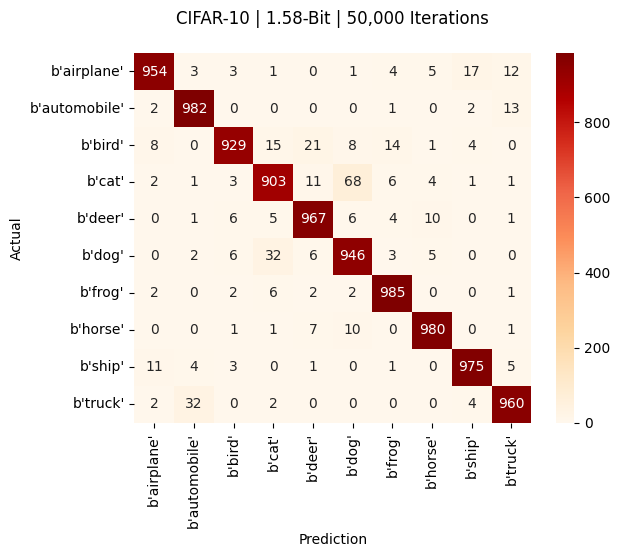

In [21]:
compute_metrics(cifar10_158bit_50000_cm.astype(int), cifar10_labels, model_name = 'CIFAR-10 | 1.58-Bit | 50,000 Iterations')

## Classification Accuracy on CIFAR-100

In [22]:
# CIFAR-100 Baseline 
checkpoint_path = "output/cifar_100/baseline_checkpoint.bin"
config = original.CONFIGS["ViT-B_16"]
cifar100_baseline_model = original.VisionTransformer(config, num_classes=100, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
cifar100_baseline_model.load_state_dict(checkpoint)

#cifar100_baseline_model

<All keys matched successfully>

In [23]:
# CIFAR-10 Accuracy for baseline model
cifar100_baseline_cm = eval_model(cifar100_baseline_model, cifar100_dataloader, cifar100_labels)

acc: 0.9279
inference time: 7.075755068206787 ms


Precision:0.9286324037430613
Recall:0.9279
F1 Score:0.928266057404555


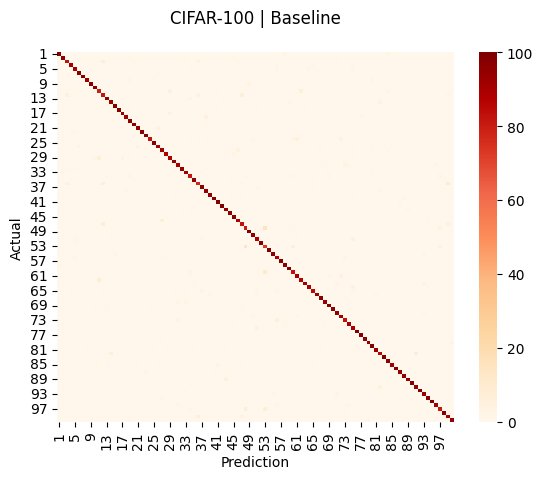

In [48]:
compute_metrics(cifar100_baseline_cm.astype(int), cifar100_labels, False, model_name = 'CIFAR-100 | Baseline')

In [25]:
# CIFAR-100 1-Bit
checkpoint_path = "output/cifar_100/1bit_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
cifar100_1bit_model = binary.VisionTransformer(config, num_classes=100, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
cifar100_1bit_model.load_state_dict(checkpoint)

#cifar100_1bit_model

<All keys matched successfully>

In [26]:
cifar100_1bit_cm = eval_model(cifar100_1bit_model, cifar100_dataloader, cifar100_labels)

acc: 0.1096
inference time: 22.002570469665528 ms


Precision:0.08285035389310984
Recall:0.1096
F1 Score:0.09436614277912157


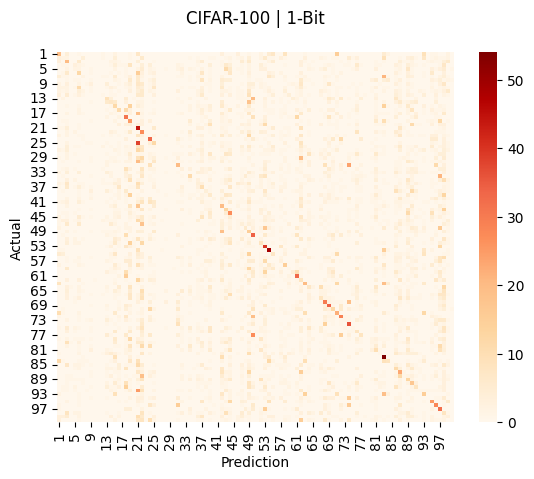

In [49]:
compute_metrics(cifar100_1bit_cm.astype(int), cifar100_labels, False, model_name = 'CIFAR-100 | 1-Bit')

In [28]:
# CIFAR-100 1.58-Bit
checkpoint_path = "output/cifar_100/bit158_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
cifar100_158bit_model = binary158.VisionTransformer(config, num_classes=100, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
cifar100_158bit_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [29]:
cifar100_158bit_cm = eval_model(cifar100_158bit_model, cifar100_dataloader, cifar100_labels)

acc: 0.6611
inference time: 32.60601030731201 ms


Precision:0.6639610831314134
Recall:0.6611
F1 Score:0.6625274527282224


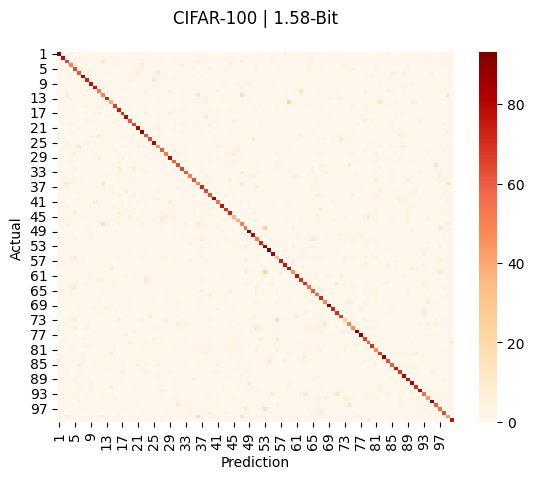

In [50]:
compute_metrics(cifar100_158bit_cm.astype(int), cifar100_labels, False, model_name = 'CIFAR-100 | 1.58-Bit')

## Visualize Attention Map

In [31]:
def show_attention_map(model, img):
    
    # apply transformation to image
    x = transform_test(img)
    x = x.unsqueeze(0)
    x = x.to(device)

    # eval model
    model.eval()
    with torch.no_grad():
        logits, att_mat = model(x)

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1), device=device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size(), device=device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    result = (mask * img).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(img)
    _ = ax2.imshow(result)

    probs = torch.nn.Softmax(dim=-1)(logits)
    top5 = torch.argsort(probs, dim=-1, descending=True)

    print("Prediction Label and Attention Map!\n")
    labels = cifar10_labels
    for idx in top5[0, :5]:
        print(f'{probs[0, idx.item()]:.5f} : {labels[idx.item()]}')
        
    torch.cuda.empty_cache()

In [32]:
img = Image.open('img/Frog-tree.jpg')

In [33]:
# Baseline finetune run
# Need to instantiate Vision transformer with vis=True to collect attention weights
checkpoint_path = "output/cifar_10/baseline_checkpoint.bin"
config = original.CONFIGS["ViT-B_16"]
baseline_model = original.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=True).to(device)
checkpoint = torch.load(checkpoint_path)
baseline_model.load_state_dict(checkpoint)

<All keys matched successfully>

Prediction Label and Attention Map!

0.99998 : b'frog'
0.00001 : b'bird'
0.00000 : b'dog'
0.00000 : b'airplane'
0.00000 : b'cat'


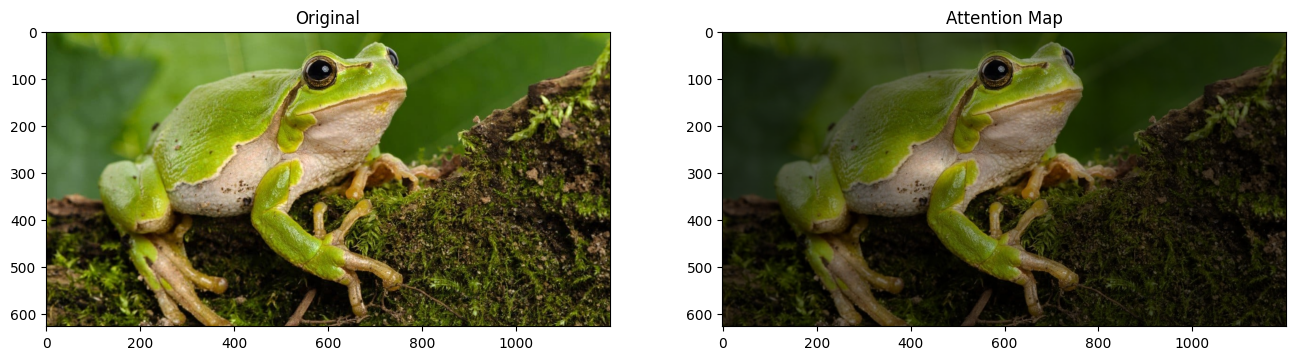

In [34]:
# 10,000 Iter full-precision on CIFAR-10
show_attention_map(baseline_model, img)

In [35]:
# Binarized Run 50,000 iterations
checkpoint_path = "output/cifar_10/config2_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
bit_model2 = binary.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=True).to(device)
checkpoint = torch.load(checkpoint_path)
bit_model2.load_state_dict(checkpoint)

<All keys matched successfully>

Prediction Label and Attention Map!

0.46698 : b'frog'
0.16556 : b'bird'
0.12053 : b'deer'
0.06338 : b'automobile'
0.04536 : b'dog'


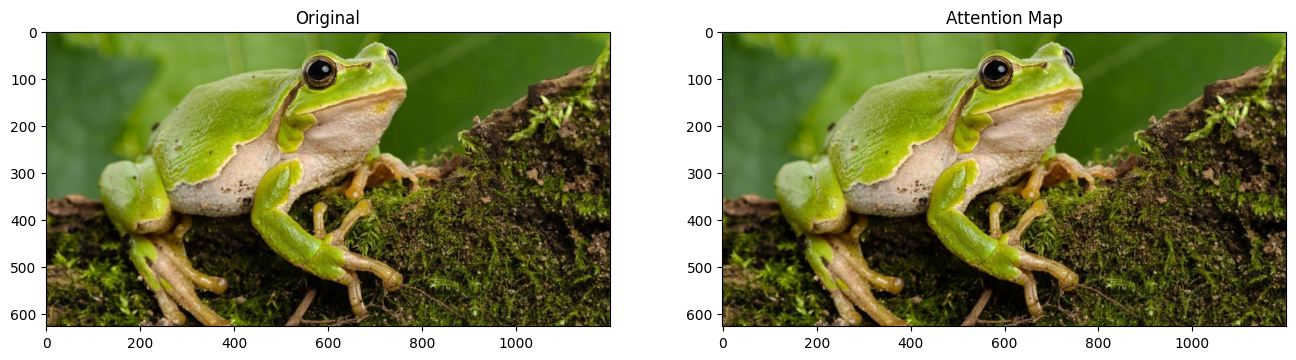

In [36]:
# 50,000 Iter 1bit-precision on CIFAR-10
show_attention_map(bit_model2, img)

In [37]:
# Bit-1.58 Run 50,000 iterations
checkpoint_path = "output/cifar_10/config3_checkpoint.bin"
config = binary158.CONFIGS["ViT-B_16"]
bit158_model = binary158.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=True).to(device)
checkpoint = torch.load(checkpoint_path)
bit158_model.load_state_dict(checkpoint)

<All keys matched successfully>

Prediction Label and Attention Map!

1.00000 : b'frog'
0.00000 : b'bird'
0.00000 : b'cat'
0.00000 : b'dog'
0.00000 : b'deer'


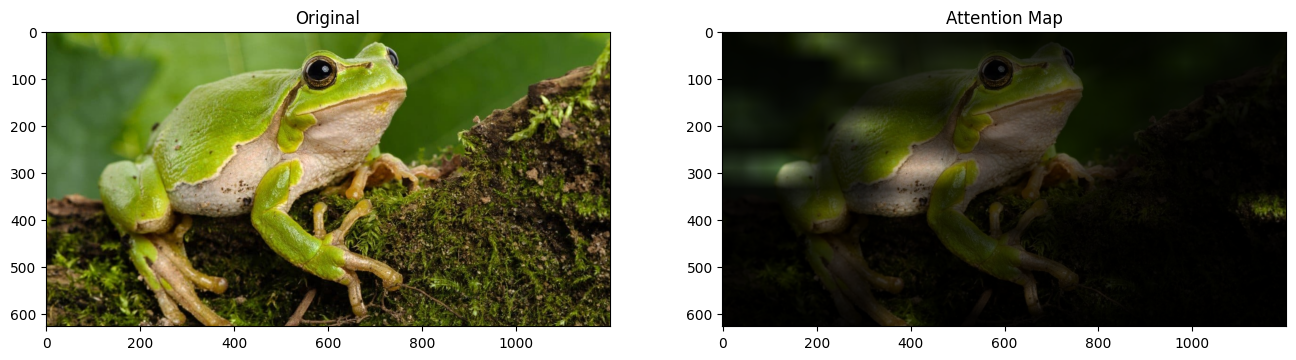

In [38]:
# 50,000 Iter 1.58bit-precision on CIFAR-10
show_attention_map(bit158_model, img)

In [39]:
img = Image.open('img/horse.jpg')

Prediction Label and Attention Map!

0.99996 : b'horse'
0.00002 : b'bird'
0.00001 : b'dog'
0.00000 : b'deer'
0.00000 : b'frog'


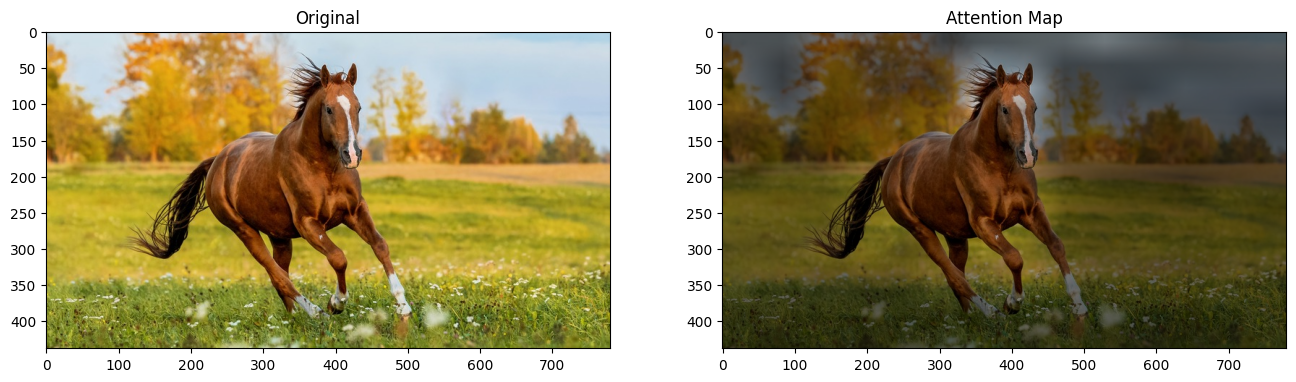

In [40]:
# full-precision
show_attention_map(baseline_model, img)

Prediction Label and Attention Map!

0.20292 : b'horse'
0.16385 : b'automobile'
0.15750 : b'truck'
0.15382 : b'airplane'
0.13397 : b'bird'


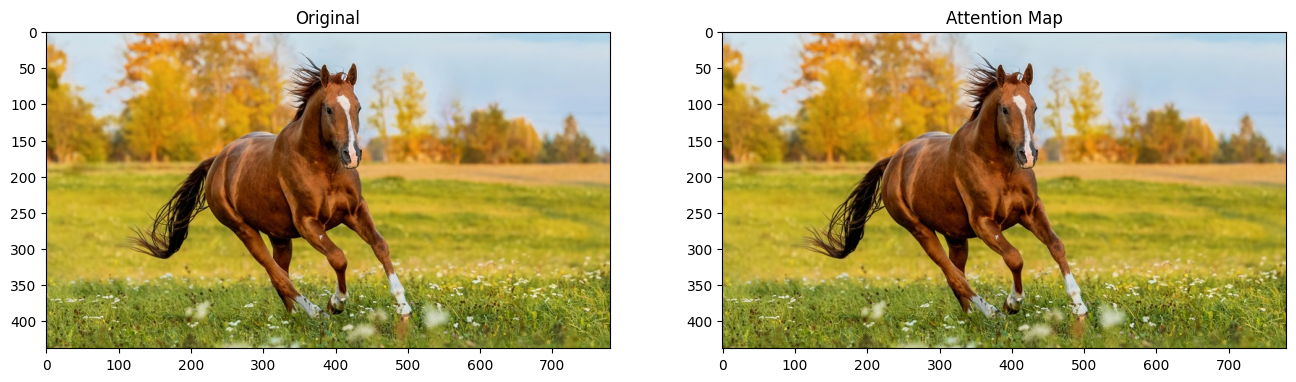

In [41]:
# 50,000 Iter 1bit-precision on CIFAR-10
show_attention_map(bit_model2, img)

Prediction Label and Attention Map!

1.00000 : b'horse'
0.00000 : b'deer'
0.00000 : b'dog'
0.00000 : b'bird'
0.00000 : b'cat'


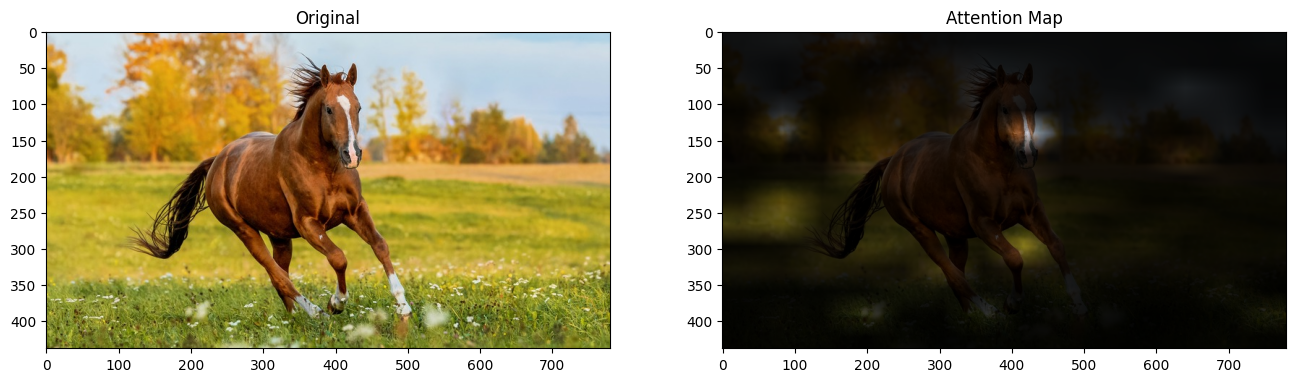

In [42]:
# 50,000 Iter 1.58bit-precision on CIFAR-10
show_attention_map(bit158_model, img)

In [43]:
img  = Image.open('img/airplane.jpg')

Prediction Label and Attention Map!

0.99998 : b'airplane'
0.00001 : b'ship'
0.00001 : b'bird'
0.00000 : b'cat'
0.00000 : b'truck'


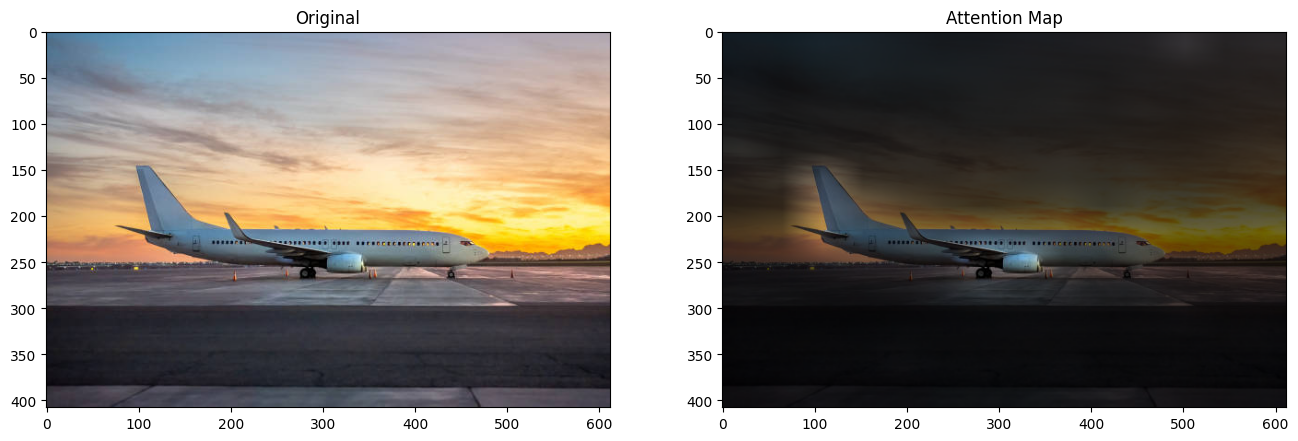

In [44]:
# baseline model
show_attention_map(baseline_model, img)

Prediction Label and Attention Map!

0.39726 : b'airplane'
0.26764 : b'truck'
0.19108 : b'automobile'
0.12499 : b'ship'
0.01714 : b'horse'


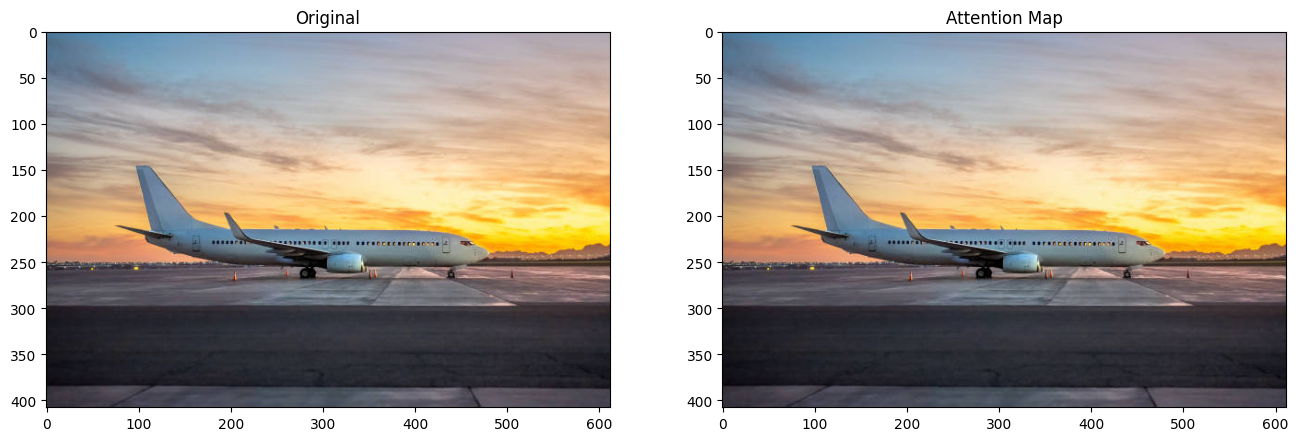

In [45]:
# 1 bit model
show_attention_map(bit_model2, img)

Prediction Label and Attention Map!

1.00000 : b'airplane'
0.00000 : b'ship'
0.00000 : b'automobile'
0.00000 : b'truck'
0.00000 : b'bird'


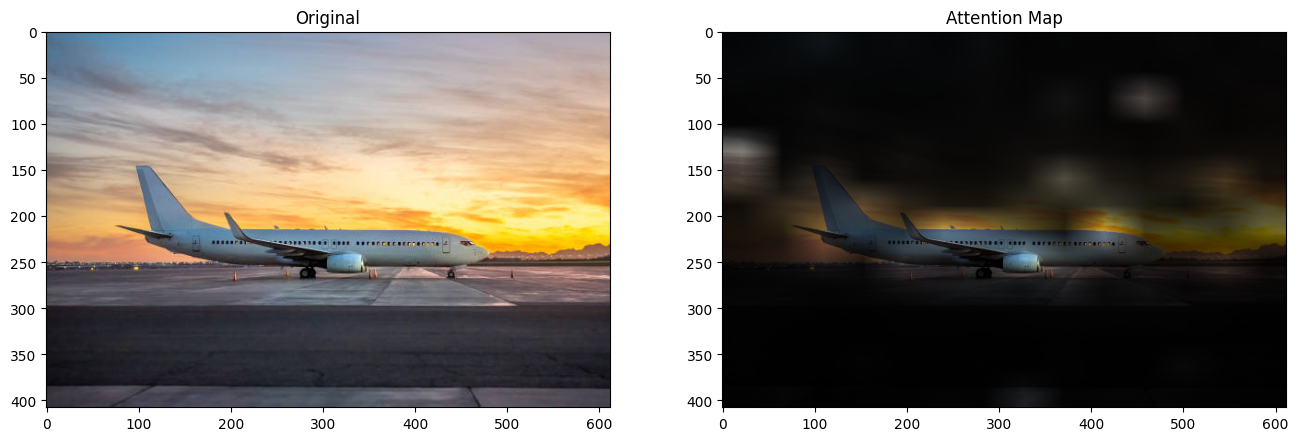

In [46]:
# 1.58 bit
show_attention_map(bit158_model, img)